In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('sqlite-sakila.db')

query_table = "Select name from sqlite_master WHERE Type='table';"
table_names = pd.read_sql_query(query_table, conn)['name'].tolist()

print(f'Tables in database :\n {table_names}')


Tables in database :
 ['actor', 'country', 'city', 'address', 'language', 'category', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'staff', 'store', 'payment', 'rental']


In [3]:
dfs = {}

for table in table_names:
    dfs[table] = pd.read_sql_query(f'Select * from {table}',conn)
    print(f'Read table {table}')

conn.close()

Read table actor
Read table country
Read table city
Read table address
Read table language
Read table category
Read table customer
Read table film
Read table film_actor
Read table film_category
Read table film_text
Read table inventory
Read table staff
Read table store
Read table payment
Read table rental


In [10]:
# rental = dfs['rental']
# inventory = dfs['inventory']
# film = dfs['film']
# film_category = dfs['film_category']
# category = dfs['category']

In [11]:
def get_datetime(df, col):
    df[col] = pd.to_datetime(df[col])
    return df

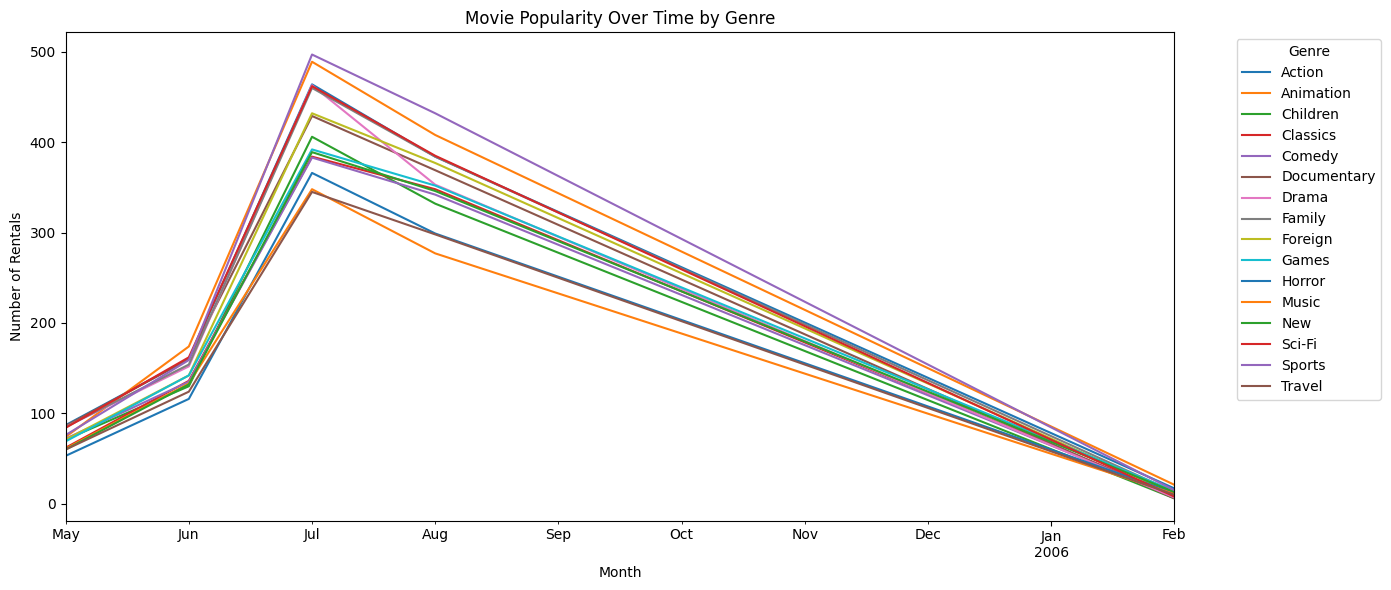

In [15]:
def plot_genre_trends(dfs):
    rental = get_datetime(dfs['rental'].copy(), 'rental_date')
    inventory = dfs['inventory'].drop(columns=['last_update'], errors='ignore')
    film = dfs['film'].drop(columns=['last_update'], errors='ignore')
    film_category = dfs['film_category'].drop(columns=['last_update'], errors='ignore')
    category = dfs['category'].drop(columns=['last_update'], errors='ignore')

    df = (
        rental.merge(inventory, on="inventory_id")
              .merge(film, on="film_id")
              .merge(film_category, on="film_id")
              .merge(category, on="category_id")
    )

    df['rental_month'] = df['rental_date'].dt.to_period("M")

    genre_month = (
        df.groupby(['rental_month', 'name'])['rental_id']
          .count()
          .reset_index(name='rentals')
    )
    pivot = genre_month.pivot(index="rental_month", columns="name", values="rentals").fillna(0)

    pivot.plot(kind="line", figsize=(14,6))
    plt.title("Movie Popularity Over Time by Genre")
    plt.xlabel("Month")
    plt.ylabel("Number of Rentals")
    plt.legend(title="Genre", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_genre_trends(dfs)


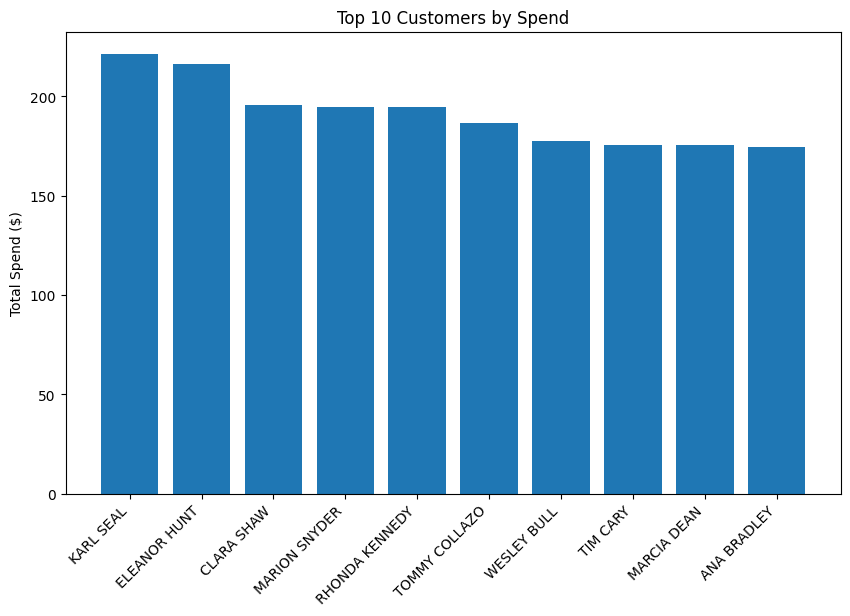

In [17]:
def plot_top_customers(dfs, top_n=10):
    payment = dfs['payment'].drop(columns=['last_update'], errors='ignore')
    customer = dfs['customer'].drop(columns=['last_update'], errors='ignore')

    df = (
        payment.merge(customer, on="customer_id")
               .groupby(['customer_id','first_name','last_name'])['amount']
               .sum()
               .reset_index()
               .sort_values(by="amount", ascending=False)
               .head(top_n)
    )

    plt.figure(figsize=(10,6))
    plt.bar(df['first_name'] + " " + df['last_name'], df['amount'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top_n} Customers by Spend")
    plt.ylabel("Total Spend ($)")
    plt.show()

plot_top_customers(dfs,10)

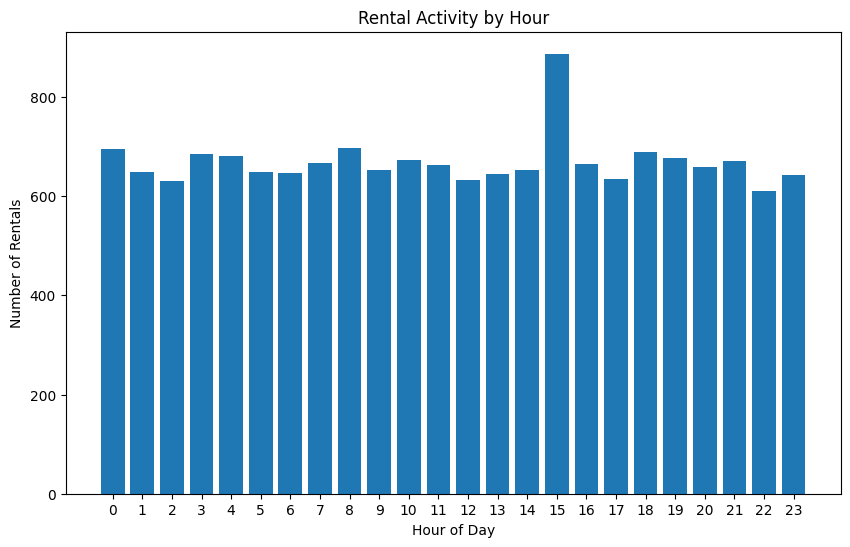

In [18]:
def plot_rental_by_hour(dfs):
    rental = get_datetime(dfs['rental'].copy(), 'rental_date')
    rental['rental_hour'] = rental['rental_date'].dt.hour

    hourly_counts = rental['rental_hour'].value_counts().sort_index()

    plt.figure(figsize=(10,6))
    plt.bar(hourly_counts.index, hourly_counts.values, width=0.8)
    plt.xticks(range(0,24))
    plt.title("Rental Activity by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Rentals")
    plt.show()

plot_rental_by_hour(dfs)